# P11 Principal Component analysis

In [1]:
## import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px ## For the radar chart
import os
os.environ["OMP_NUM_THREADS"] = '1' ## To avoid KMeans memory leak

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from IPython.display import display ## Allows to display several clean data frames from one cell
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

## 1_Prepare data
Here we will import the compiled data frame with all the variables and scale it. The PCA needs to be done on scaled data, expecially when we have such diverse variables as us.

In [2]:
## Import data
print("Whole table")
all_data_raw = pd.read_csv("../Data/df_for_PCA.csv")
display( all_data_raw.head() )

## Select the columns to scale
data_to_scale = all_data_raw.loc[:, 'consumer_price_index':'import_price']
data_to_scale.index = all_data_raw['country']

## Scaling
scaled_data = StandardScaler().fit_transform(data_to_scale)

## Add country code as index
print("\nScaled data in a readable format")
scaled_data_df = pd.DataFrame(scaled_data, 
                              columns = data_to_scale.columns,
                              index = data_to_scale.index)

scaled_data_df

Whole table


country  M49 ISO2 ISO3  consumer_price_index    gdp_dollar  \
0  Algeria   12   DZ  DZA            166.218895  1.862310e+11   
1    Egypt  818   EG  EGY            318.936481  4.246720e+11   
2    Libya  434   LY  LBY            260.082820  3.521800e+10   
3  Morocco  504   MA  MAR            113.419775  1.420220e+11   
4    Sudan  729   SD  SDN          16245.888970  3.422951e+10   

   ease_business_2019  logistics_performance_2018  political_stability  \
0               157.0                        2.45            -0.992457   
1               114.0                        2.82            -1.032864   
2               186.0                        2.11            -2.308474   
3                53.0                        2.54            -0.402563   
4               171.0                        2.43            -1.987674   

    population  corruption  chicken_consumption  import_qt  import_value  \
0   44761099.0        33.0            271904.25       0.40           1.0   
1  110957008.0        33.0           2425360.74   25589.72       94639.0   
2    7135175.0        17.0            260741.76  129707.09      220964.0   
3   36954442.0        39.0            529565.19    4575.66        2985.0   
4   48066924.0        20.0             80000.00    1348.25        2388.0   

   GDP_capita  chicken_capita  import_price  
0     4160.55           6.075          2.50  
1     3827.36          21.859          3.70  
2     4935.83          36.543          1.70  
3     3843.16          14.330          0.65  
4      712.12           1.664          1.77


Scaled data in a readable format


consumer_price_index  gdp_dollar  ease_business_2019  \
country                                                                 
Algeria                     -0.146870   -0.152508            1.139890   
Egypt                       -0.073932   -0.047605            0.353588   
Libya                       -0.102041   -0.218946            1.670187   
Morocco                     -0.172086   -0.171958           -0.761863   
Sudan                        7.532701   -0.219381            1.395896   
...                               ...         ...                 ...   
Solomon Islands             -0.160897   -0.233770            0.755882   
Vanuatu                     -0.165952   -0.234022            0.225586   
Kiribati                    -0.176003   -0.234313            1.267893   
Samoa                       -0.169260   -0.234069            0.061011   
Tonga                       -0.161510   -0.234212            0.152441   

                 logistics_performance_2018  political_stability  population  \
country                                                                        
Algeria                           -0.700364            -0.906482    0.011233   
Egypt                             -0.011769            -0.948757    0.443901   
Libya                             -1.333127            -2.283346   -0.234696   
Morocco                           -0.532868            -0.289313   -0.039793   
Sudan                             -0.737586            -1.947714    0.032841   
...                                     ...                  ...         ...   
Solomon Islands                   -0.477036             0.698791   -0.276349   
Vanuatu                           -0.505510             1.074003   -0.279334   
Kiribati                          -0.635041             1.321667   -0.280494   
Samoa                             -0.498624             1.291061   -0.279936   
Tonga                             -0.515002             1.261105   -0.280644   

                 corruption  chicken_consumption  import_qt  import_value  \
country                                                                     
Algeria           -0.588175            -0.186021  -0.435769     -0.386283   
Egypt             -0.588175             0.952183  -0.289867     -0.112182   
Libya             -1.454335            -0.191921   0.303779      0.253695   
Morocco           -0.263365            -0.049835  -0.409682     -0.377641   
Sudan             -1.291930            -0.287451  -0.428084     -0.379370   
...                     ...                  ...        ...           ...   
Solomon Islands   -0.046825            -0.327074  -0.408682     -0.354574   
Vanuatu            0.061445            -0.326861  -0.408291     -0.353986   
Kiribati           0.464209            -0.329137  -0.434964     -0.385377   
Samoa              0.597922            -0.321698  -0.321175     -0.329382   
Tonga              0.484780            -0.323202  -0.366714     -0.349952   

                 GDP_capita  chicken_capita  import_price  
country                                                    
Algeria           -0.511394       -0.821993      0.724503  
Egypt             -0.526246        0.029626      2.014674  
Libya             -0.476835        0.821894     -0.135611  
Morocco           -0.525542       -0.376598     -1.264510  
Sudan             -0.665112       -1.059987     -0.060351  
...                     ...             ...           ...  
Solomon Islands   -0.607843       -0.793505      0.509475  
Vanuatu           -0.558348       -0.190455      0.520226  
Kiribati          -0.596388       -0.673780      0.423464  
Samoa             -0.520884        2.687966     -0.909713  
Tonga             -0.477871        5.172250     -0.845205  

[181 rows x 13 columns]

## 2_Perform PCA
Here we will perform the PCA calculation. First of all we will chose the number of dimensions with which we want to work.

### 2.1_Calculate PCA with many PC

In [3]:
## Calculate PCA with 13 components
pca = PCA(n_components = 13, random_state = 68)

# Fit and transform the scaled data
pca_result = pca.fit_transform(scaled_data)

# Generate components names
comp_names = [f'PC{i}' for i in range(1, 14)]
# Create a DataFrame with the PCA results
pca_df = pd.DataFrame(data = pca_result,
                     columns = comp_names,
                     index = data_to_scale.index)

pca_df


PC1       PC2       PC3       PC4       PC5       PC6  \
country                                                                       
Algeria         -1.532393  0.449590  0.855049 -0.392598 -0.616691  0.934433   
Egypt           -0.080281  0.753299  1.268242 -1.195945 -0.211710  1.076136   
Libya           -2.291951  1.533232 -0.341030 -0.324167  0.771376  1.646843   
Morocco         -0.914697  0.117773 -0.560986  0.168981 -0.517649 -1.162448   
Sudan           -3.345053  1.977834  4.801859  2.120355  4.550591 -1.636275   
...                   ...       ...       ...       ...       ...       ...   
Solomon Islands -0.867156 -0.459464  0.284258 -0.245513 -0.553241  0.446182   
Vanuatu         -0.451414 -0.797031 -0.072869 -0.455830 -0.216637  0.191822   
Kiribati        -0.776931 -0.749445  0.037126 -0.436263 -0.365428  0.527155   
Samoa           -0.030854 -1.229057 -2.152125 -1.185929  1.725871 -0.545960   
Tonga            0.248426 -1.580675 -3.170433 -2.264200  3.362744 -0.308578   

                      PC7       PC8       PC9      PC10      PC11      PC12  \
country                                                                       
Algeria          0.164992  0.202959 -0.016032  0.029041  0.266756  0.047101   
Egypt           -0.418535  0.964691 -0.816967  0.424683  0.112771  0.331840   
Libya           -1.011604  0.627809  0.612221 -0.341573  0.201207 -0.203954   
Morocco         -0.479371 -0.279372 -0.158223 -0.484111 -0.073611  0.084743   
Sudan            0.702109 -0.025745 -0.371021  0.184258  0.135518  0.021354   
...                   ...       ...       ...       ...       ...       ...   
Solomon Islands  1.039323 -0.356120 -0.463206  0.246975  0.046062  0.091043   
Vanuatu          0.946598 -0.240632 -0.727195  0.061844 -0.130260  0.006014   
Kiribati         1.774518 -0.599847 -0.250169  0.285836  0.246942  0.293914   
Samoa            0.366122  0.104223 -0.020451 -0.113221  0.241018 -0.187298   
Tonga           -0.219541  0.835448  0.150869 -0.071705  0.274280 -0.581887   

                     PC13  
country                    
Algeria         -0.079525  
Egypt            0.155173  
Libya            0.017343  
Morocco          0.123550  
Sudan           -0.033511  
...                   ...  
Solomon Islands -0.049567  
Vanuatu         -0.045646  
Kiribati        -0.062399  
Samoa            0.008889  
Tonga            0.014656  

[181 rows x 13 columns]

### 2.2 Choose the number of dimensions
To choose the number of dimensions, we will check the eigenvalues of each component. Our method will be the following:

- Method 1: If a few components have a largely higher eigenvalue than the rest, then we chose these ones.
- Method 2: If it is not so clear, then we will make a line plot with the eigenvalue of each component and see if we see an "elbow", in which case we would take only the components before the elbow.
- Method 3: If it is still not clear, then we will calculate the cumulative percentage of explained variance per component and take all the components until that we explain 80% of the total variance of our data.

#### Method 1: Check the eigenvalues

In [4]:
## Access the eigenvalues
eigenvals = pca.explained_variance_
eigen_df = pd.DataFrame({'PC' : comp_names,
                        'eigenvalue' : eigenvals})

eigen_df

PC  eigenvalue
0    PC1    4.789614
1    PC2    3.058764
2    PC3    1.176154
3    PC4    1.007176
4    PC5    0.893034
5    PC6    0.612090
6    PC7    0.437213
7    PC8    0.368285
8    PC9    0.307422
9   PC10    0.159711
10  PC11    0.125827
11  PC12    0.095684
12  PC13    0.041248

While the first 3 components are obviously important, and the components beyond PC6 are clearly not to be kept, it is not clear if we should stop at PC4, 5 or 6. We will plot them.
#### Method 2: the lineplot

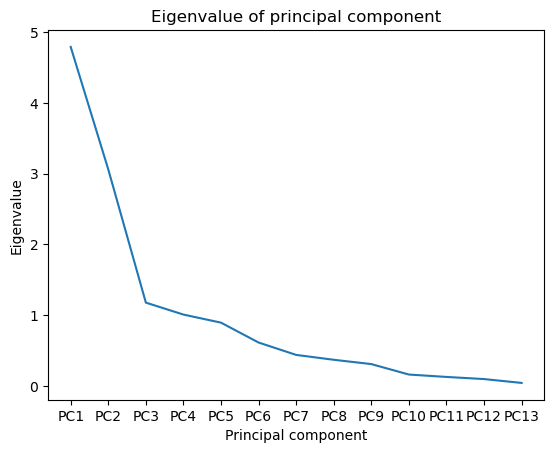

In [5]:
## Create lineplot
plt.plot(eigen_df['PC'], eigen_df['eigenvalue'])
plt.xlabel('Principal component')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalue of principal component')

plt.show()

It seems that we could take only the first 3 components.
We will check how much of the variability we lose if doing so, using the third method.
#### Method 3: Cumulative explained variance

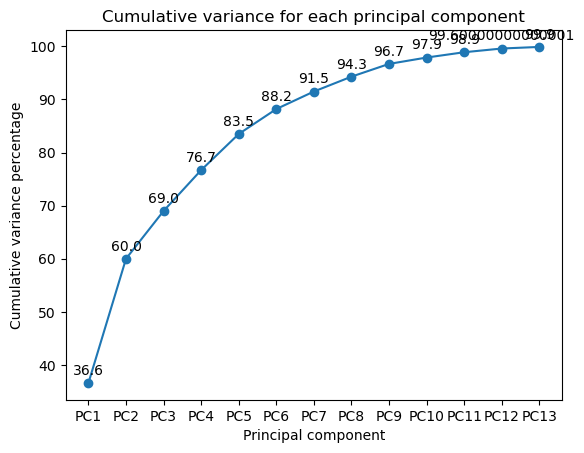

In [6]:
## Calculate the percentage of variation of each PC
eigen_df['var_prct'] = round( ( eigen_df['eigenvalue'] / eigen_df['eigenvalue'].sum() * 100),
                             1)

## Calculate the cumulative sum
eigen_df['var_cumsum'] = eigen_df['var_prct'].cumsum()

## Plot the cumulative sum
plt.plot(eigen_df['PC'], eigen_df['var_cumsum'], marker = 'o')
plt.xlabel('Principal component')
plt.ylabel('Cumulative variance percentage')
plt.title('Cumulative variance for each principal component')

## Add data label
for i in range(len(eigen_df)):
    plt.text(i,
             eigen_df['var_cumsum'][i] + 1,
             eigen_df['var_cumsum'][i],
             ha='center', va='bottom')

plt.show()

Taking only the first 3 PC would mean that we have 31% of the variability of our samples missing, which is too high in my opinion. Taking 4 PC make us miss 23% of variability, taking 5, 17%.

I would like to explain at least 80% of the variability, then we will take the first 5 PC.

### 2.3_Recalculate with 5 components
Here we redo the calculations and create the objects we will work with.

In [7]:
## Reset PCS with 5 components
## Calculate PCA with 12 components
pca = PCA(n_components = 5, random_state = 68)

# Fit and transform the scaled data
pca_result = pca.fit_transform(scaled_data)

# Generate components names
comp_names = [f'PC{i}' for i in range(1, 6)]
# Create a DataFrame with the PCA results
pca_df = pd.DataFrame(data = pca_result,
                     columns = comp_names,
                     index = data_to_scale.index)

pca_df.head()

PC1       PC2       PC3       PC4       PC5
country                                                  
Algeria -1.532393  0.449590  0.855049 -0.392598 -0.616691
Egypt   -0.080281  0.753299  1.268242 -1.195945 -0.211710
Libya   -2.291951  1.533232 -0.341030 -0.324167  0.771376
Morocco -0.914697  0.117773 -0.560986  0.168981 -0.517649
Sudan   -3.345053  1.977834  4.801859  2.120355  4.550591

## 3_Interpret PCA
Now that we know what we work with, we can interpret the results. First of all we will check which variables are correlated to which components by chcêcking the loadings of our components. Then we will make graphical representations of each country across these 5 components, and at last we will cluster the countries together based on these components.

### 3.1_Understand the meaning of the components

First of all, we multiply the component coefficients (pca.components_.T, 1 row per variable, 1 column per component) by the square root of the explained variance np.sqrt(pca.explained_variance_). The component coefficients show the importance of each variable for each separate Principal Component. We multiply it by the square root of the variance to express the importance of each variable in the context of the total variance of our data. This allows to compare the columns between each other.

In [8]:
## Get the loadings
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

## make a df out of it
variable_names = all_data_raw.columns[4:17]
loadings_df = pd.DataFrame(loadings, columns = comp_names[0:5], index = variable_names)

loadings_df

PC1       PC2       PC3       PC4       PC5
consumer_price_index       -0.248699  0.180348  0.571142  0.279605  0.655446
gdp_dollar                  0.618004  0.587643  0.155309 -0.328484  0.010141
ease_business_2019         -0.762305  0.265058  0.028645 -0.142518  0.137280
logistics_performance_2018  0.866840 -0.207600  0.124808  0.203588 -0.074257
political_stability         0.566435 -0.584372 -0.254895 -0.107962  0.037470
population                  0.359137  0.715032  0.052632 -0.186351 -0.164714
corruption                  0.791257 -0.505355 -0.014140  0.061365  0.019292
chicken_consumption         0.540190  0.691669  0.072715 -0.384084  0.034136
import_qt                   0.549285  0.572642 -0.306516  0.436328  0.126343
import_value                0.635057  0.591972 -0.187934  0.348078  0.079974
GDP_capita                  0.752015 -0.405073  0.267653  0.106825  0.043431
chicken_capita              0.312538 -0.259282 -0.476429 -0.412873  0.619411
import_price                0.526662 -0.267111  0.555255 -0.261248 -0.031236

#### Plot the loadings

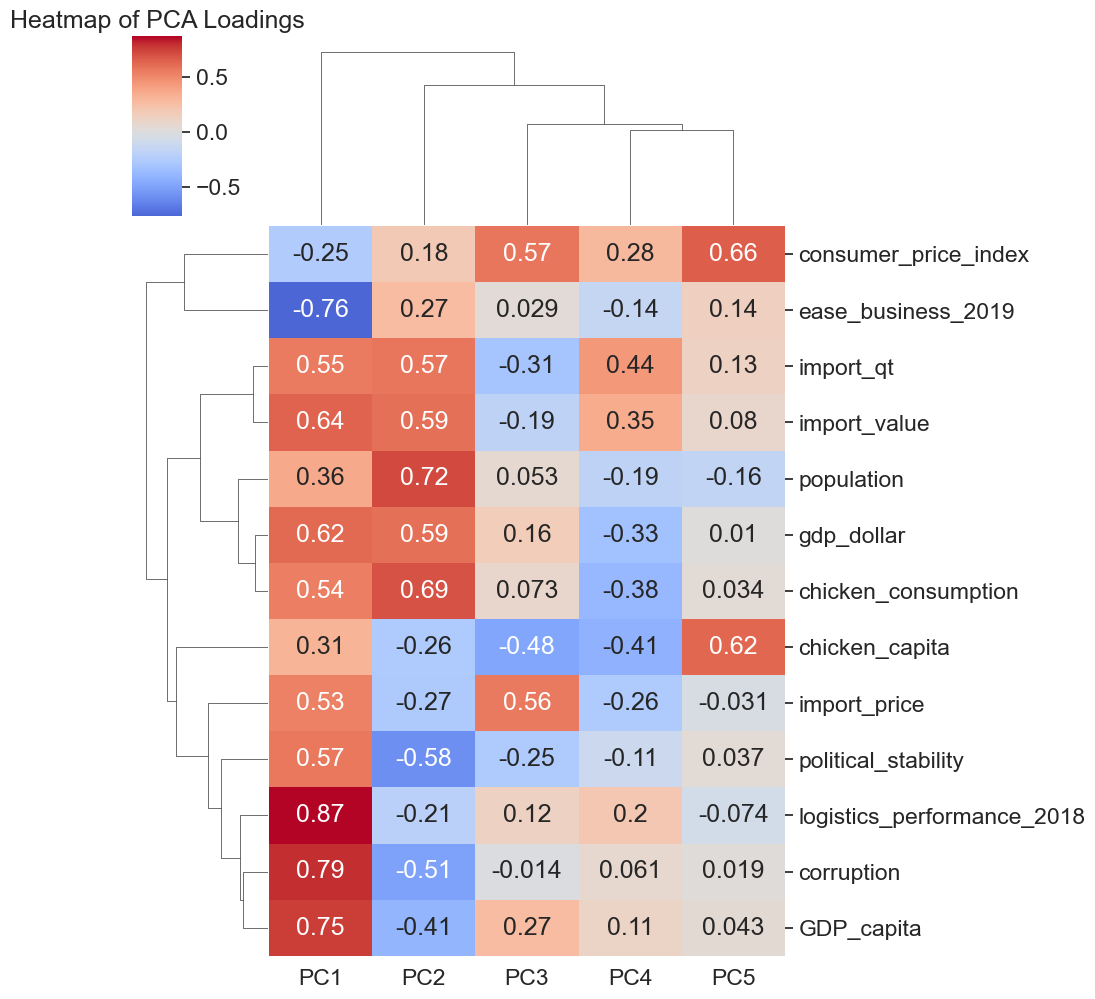

In [9]:
## Create clustermap
sns.set(font_scale = 1.5)
sns.clustermap(loadings_df, annot=True,
               cmap='coolwarm', center=0)
plt.title('Heatmap of PCA Loadings')
plt.show()

sns.set(font_scale = 1)

We now see which variables are linked to which Principal Component. The most notable points are:

- PC1 is strongly correlated to the **GDP per capita, the logistics performance index and the corruption perception index**. It is strongly anticorrelated to the **index of ease of doing business** (lowest index = greater ease).
- PC2 is strongly correlated to the **country population, country chicken consumption**, moderately correlated to **the chicken import quantity and value, and the country GDP**. It is anticorrelated to the **political stability index and corruption index**.
- PC3 is correlated to **chicken import price and the consumer index price**.
- PC4 is mildly correlated to **chicken import quantity**, but mildly anticorrelated to **chicken consumption per capita and country chicken consumption**.
- PC5 is correlated to the **consumer price index and chicken consumption per capita**.

Our interpretation of each component:

- PC1: Performance and organization of the economy.
- PC2: Country population size and political instability.
- PC3: Price of imported goods in general.
- PC4: Low chicken production (low consumption despite higher imports).
- PC5: Countries with high overall prices and chicken consumption.

At this stage it is also interesting to know which variable is correlated with one another.

#### Plot correlations between the variables

<Figure size 1400x1000 with 0 Axes>

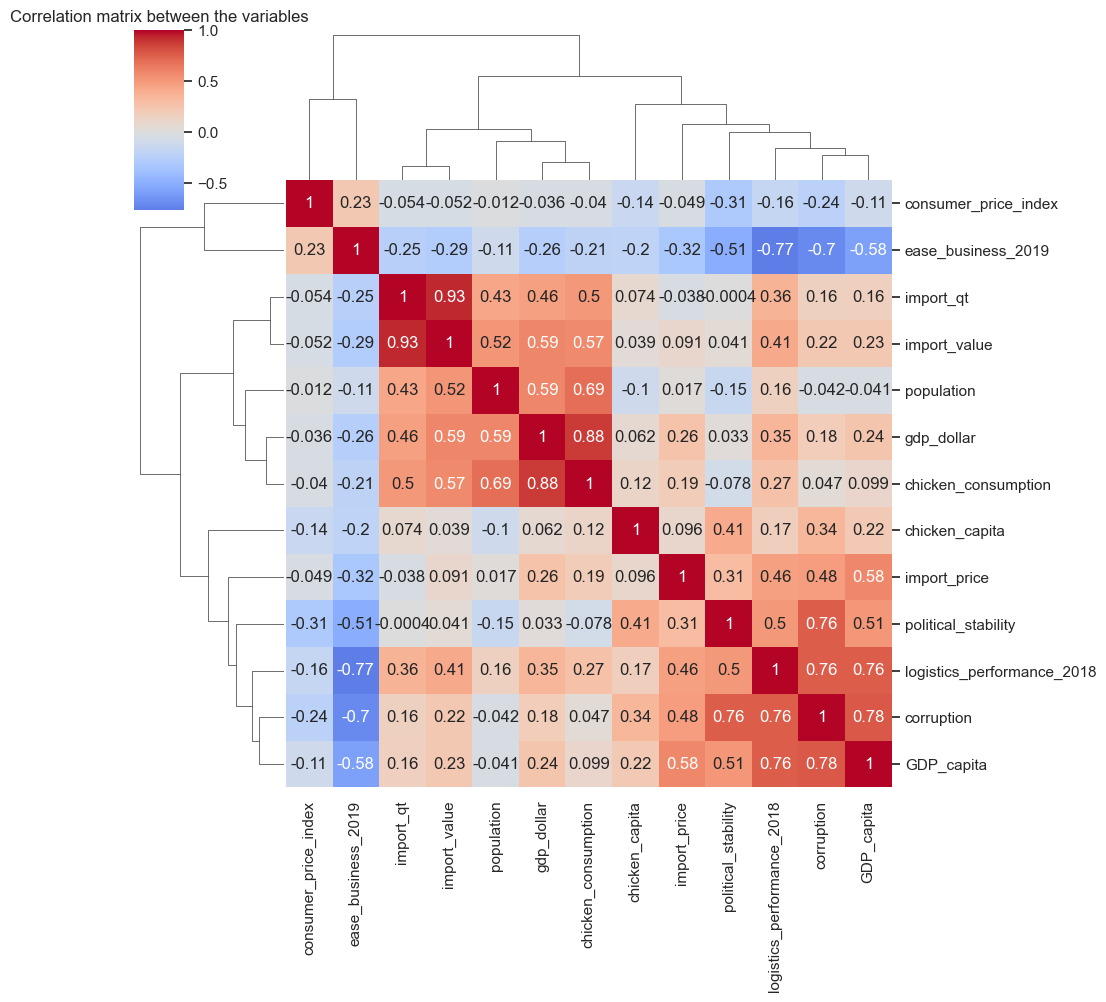

In [10]:
corr_variables = scaled_data_df.corr()

plt.figure(figsize=(14, 10))
sns.clustermap(corr_variables, annot = True, 
               cmap = 'coolwarm', center = 0)
plt.title('Correlation matrix between the variables')
plt.show()

There are a lot of strong correlations in our data. The most notable points are:

- The **political stability** index and the **corruption index** are perfectly correlated, and both are strongly anticorrelated to the **index of ease of doing business**.
- There is a big correlation cluster between **chiken import price, the country gdp, the country chicken consumption, the logistics performance index** and **the country population**.
- The second big correlation cluster is between the **GDP per capita, chicken per capita, import quantity and import value**
- The **GDP per capita** is anticorrelated to **the consumer price index**.

### 3.2_Clustering

For the clustering, we will use the K-Means algorithm.
Firstly we will choose the number of clusters, then we will perform the clustering and plot it.

#### Determine the number of clusters
To choose the number of clusters, we will calculate inertia (distance between each point and the center of their cluster) for a varying number of clusters. We will plot it and look for an inflexion point, which should be an appropriate number of clusters.

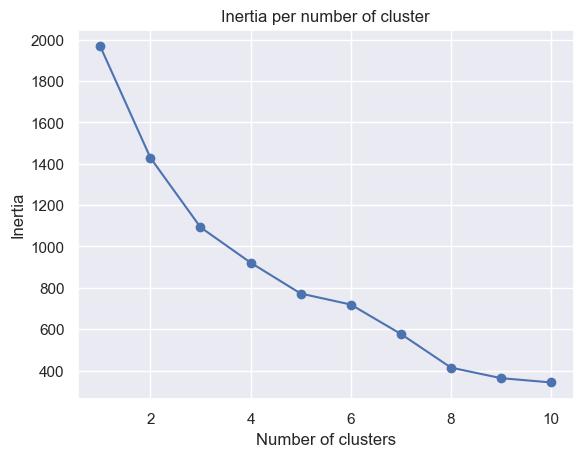

In [11]:
## Create empty intertia array
inertias = []

## Loop K-means calculation
for i in range(1,11):
    kmeans = KMeans(n_clusters = i, random_state = 68)
    kmeans.fit(pca_df)
    inertias.append(kmeans.inertia_)

## Plot inertia array
plt.plot( range(1,11), inertias, marker='o')
plt.title('Inertia per number of cluster')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show() 

Here a good value could be 5 clusters, however adding more clusters can create smaller clusters of "outlier countries" which are separated from all the others. Leaving these apart can greatly improve the consistency of each cluster while setting apart very few individuals. We will take 8 clusters.

In [12]:
## Proceed to the clustering with 8 clusters
kmeans = KMeans(n_clusters = 8, random_state = 68 )
kmeans.fit(pca_df)

## Add the cluster names to pca_df
pca_df['cluster'] = kmeans.predict(pca_df )
pca_df.head()

PC1       PC2       PC3       PC4       PC5  cluster
country                                                           
Algeria -1.532393  0.449590  0.855049 -0.392598 -0.616691        0
Egypt   -0.080281  0.753299  1.268242 -1.195945 -0.211710        2
Libya   -2.291951  1.533232 -0.341030 -0.324167  0.771376        0
Morocco -0.914697  0.117773 -0.560986  0.168981 -0.517649        2
Sudan   -3.345053  1.977834  4.801859  2.120355  4.550591        5

#### Check the cluster size and composition

In [13]:
pca_df['cluster'].value_counts()

cluster
2    62
0    52
1    40
3    14
6     9
5     2
7     1
4     1
Name: count, dtype: int64

The clusters 7, 5 and 4 stand out as outliers cluster as described above. Let's check each cluster separately.

In [14]:
pca_df[pca_df['cluster'] == 0].index

Index(['Algeria', 'Libya', 'Burundi', 'Comoros', 'Djibouti', 'Ethiopia',
       'Madagascar', 'Mozambique', 'Somalia', 'Uganda',
       'United Republic of Tanzania', 'Zimbabwe', 'Angola', 'Cameroon',
       'Central African Republic', 'Chad', 'Congo',
       'Democratic Republic of the Congo', 'Equatorial Guinea', 'Eswatini',
       'Benin', 'Burkina Faso', 'Gambia', 'Guinea', 'Guinea-Bissau', 'Liberia',
       'Mali', 'Mauritania', 'Niger', 'Nigeria', 'Senegal', 'Sierra Leone',
       'Togo', 'Haiti', 'Honduras', 'Nicaragua',
       'Venezuela (Bolivarian Republic of)', 'Kyrgyzstan', 'Tajikistan',
       'Turkmenistan', 'Cambodia', 'Timor-Leste', 'Afghanistan', 'Bangladesh',
       'India', 'Iran (Islamic Republic of)', 'Pakistan', 'Iraq', 'Lebanon',
       'Syrian Arab Republic', 'Yemen', 'Papua New Guinea'],
      dtype='object', name='country')

The cluster 0 contains many least developed or developing countries from Africa, South America Middle East and Asia.

In [15]:
pca_df[pca_df['cluster'] == 1].index

Index(['Mauritius', 'Seychelles', 'Antigua and Barbuda', 'Bahamas', 'Barbados',
       'Dominica', 'Grenada', 'Saint Kitts and Nevis', 'Saint Lucia',
       'Saint Vincent and the Grenadines', 'Costa Rica', 'Panama', 'Chile',
       'Guyana', 'Uruguay', 'Republic of Korea', 'Brunei Darussalam',
       'Malaysia', 'Bahrain', 'Cyprus', 'Israel', 'Kuwait', 'Oman', 'Qatar',
       'Czechia', 'Hungary', 'Poland', 'Slovakia', 'Estonia', 'Latvia',
       'Lithuania', 'Croatia', 'Greece', 'Italy', 'Malta', 'Portugal',
       'Slovenia', 'Spain', 'Samoa', 'Tonga'],
      dtype='object', name='country')

This cluster contains many islands, most of South America, the least wealthy European countries and the wealthiest sub-saharan African countries.

In [16]:
pca_df[pca_df['cluster'] == 2].index

Index(['Egypt', 'Morocco', 'Tunisia', 'Kenya', 'Malawi', 'Rwanda', 'Zambia',
       'Gabon', 'Sao Tome and Principe', 'Botswana', 'Lesotho', 'Namibia',
       'South Africa', 'Cabo Verde', 'Côte d’Ivoire', 'Ghana',
       'Dominican Republic', 'Jamaica', 'Trinidad and Tobago', 'Belize',
       'El Salvador', 'Guatemala', 'Argentina',
       'Bolivia (Plurinational State of)', 'Brazil', 'Colombia', 'Ecuador',
       'Paraguay', 'Peru', 'Suriname', 'Kazakhstan', 'Uzbekistan', 'Mongolia',
       'Indonesia', 'Lao People's Democratic Republic', 'Philippines',
       'Thailand', 'Viet Nam', 'Bhutan', 'Maldives', 'Nepal', 'Sri Lanka',
       'Armenia', 'Azerbaijan', 'Georgia', 'Jordan', 'Türkiye', 'Belarus',
       'Bulgaria', 'Republic of Moldova', 'Romania', 'Russian Federation',
       'Ukraine', 'Albania', 'Bosnia and Herzegovina', 'Montenegro',
       'North Macedonia', 'Serbia', 'Fiji', 'Solomon Islands', 'Vanuatu',
       'Kiribati'],
      dtype='object', name='country')

This cluster contains many islands as well as developing countries from every continent.

In [17]:
pca_df[pca_df['cluster'] == 3].index

Index(['Canada', 'Singapore', 'Denmark', 'Finland', 'Iceland', 'Ireland',
       'Norway', 'Sweden', 'Austria', 'Belgium', 'Luxembourg', 'Switzerland',
       'Australia', 'New Zealand'],
      dtype='object', name='country')

This cluster contains many of the most developed countries in the world.

In [18]:
pca_df[pca_df['cluster'] == 4].index

Index(['China'], dtype='object', name='country')

This is the first outlier cluster, with China.

In [19]:
pca_df[pca_df['cluster'] == 5].index

Index(['Sudan', 'South Sudan'], dtype='object', name='country')

This is the second "outlier cluster". South Sudan and Sudan were at war until few years before 2021 and the humanitarian situation was known to be dire.

In [20]:
pca_df[pca_df['cluster'] == 6].index

Index(['Mexico', 'China Hong Kong Special Administrative Region', 'Japan',
       'Saudi Arabia', 'United Arab Emirates',
       'United Kingdom of Great Britain and Northern Ireland', 'France',
       'Germany', 'Netherlands (Kingdom of the)'],
      dtype='object', name='country')

This is another cluster of the wealthiest countries in the world, as well as Mexico.

In [21]:
pca_df[pca_df['cluster'] == 7].index

Index(['United States of America'], dtype='object', name='country')

This is the third outlier cluster, with  the United States of America.

This cluster contains many of the least developped countries in the world.

### 3.3_Create pairplot of the PCA

#### Create pairplot

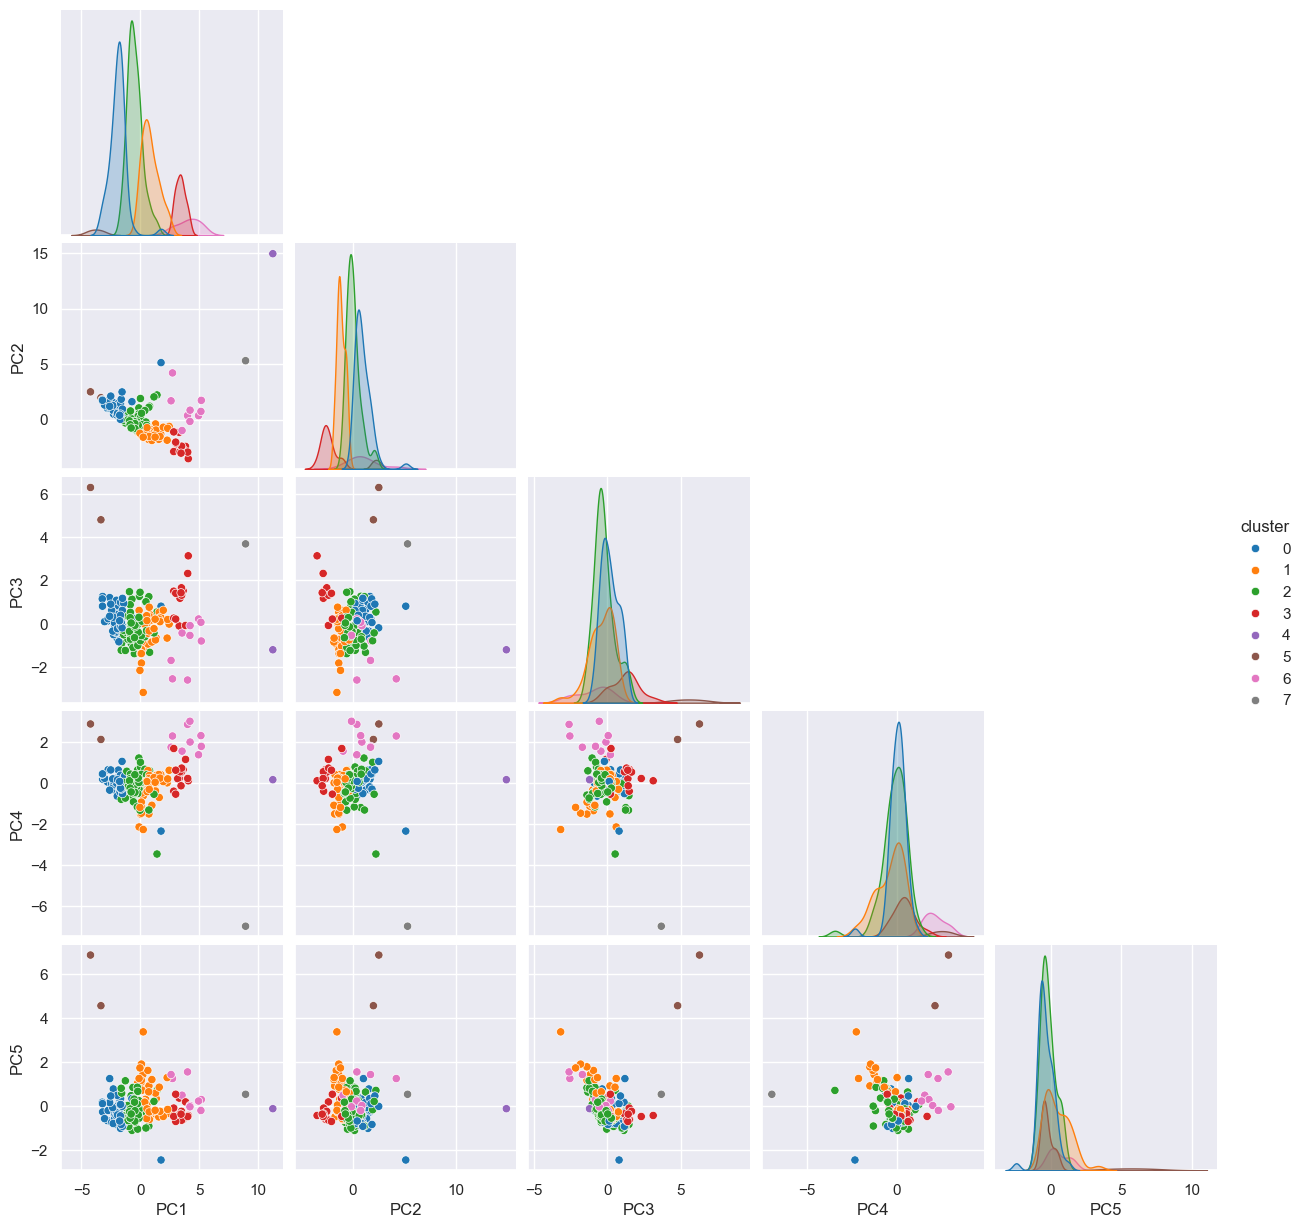

In [22]:
## Plot pairplot with the clusters
sns.pairplot(pca_df,
            hue = 'cluster',
            corner = True,
            palette = "tab10")

Here plotting the PC1 and PC2 seem to give the best groups separation. Let's plot the correlation circle for these two components.

<Axes: xlabel='PC1', ylabel='PC2'>

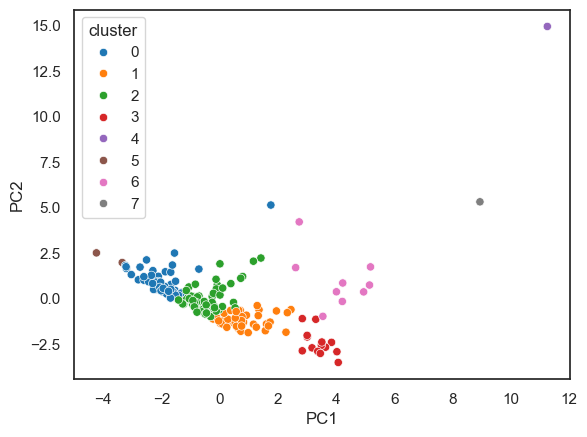

In [23]:
sns.set_theme(style = 'white')
sns.scatterplot(pca_df,
                x = 'PC1',
                y = 'PC2',
                hue = 'cluster',
                palette = "tab10")

#### Plot correlation circle

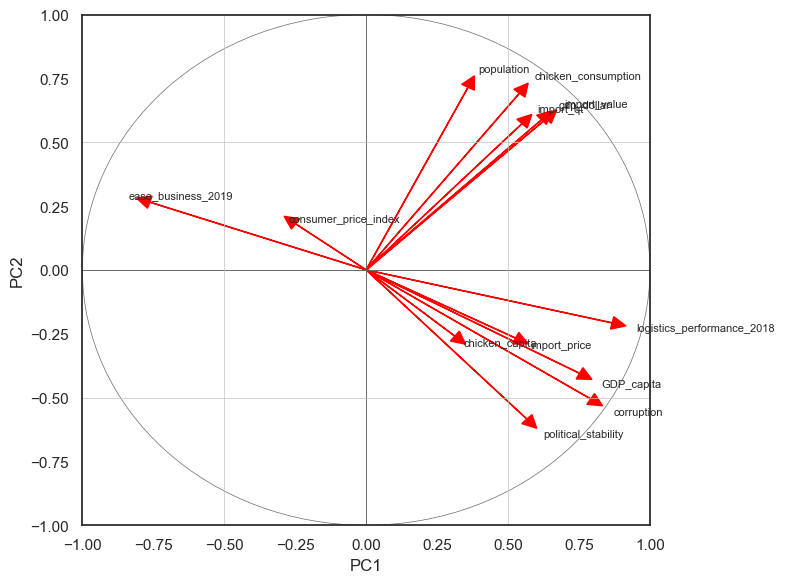

In [24]:
# Define correlation circles plotting function
def plot_correlation_circle(loadings, pc1, pc2, fig):
    
    for i, (val1, val2, index) in enumerate( zip(loadings_df[pc1], loadings_df[pc2], loadings.index) ):
        fig.arrow(0, 0, val1, val2, 
                 head_width = 0.05, head_length = 0.05, 
                 fc = 'red', ec = 'red')
        fig.text( (val1 + val1*0.1), (val2 + val2*0.1), 
                index, fontsize = 8, 
                ha='left', va='center')
    fig.set_xlim(-1, 1)
    fig.set_ylim(-1, 1)
    fig.set_xlabel(f'{pc1}')
    fig.set_ylabel(f'{pc2}')

    ## Add main axes
    fig.axhline(0, color='dimgrey', linewidth=0.7)
    fig.axvline(0, color='dimgrey', linewidth=0.7)
    ## Add secondary axes
    fig.axhline(0.5, color='silver',  linewidth=0.5)
    fig.axhline(-0.5, color='silver', linewidth=0.5)
    fig.axvline(0.5, color='silver',  linewidth=0.5)
    fig.axvline(-0.5, color='silver', linewidth=0.5)

    ## Add a circle
    circle = plt.Circle((0, 0), 1, 
                        color = 'dimgrey', fill = False,
                        linewidth=0.5)
    fig.add_artist(circle)

    
## Run function
fig1, fig = plt.subplots(figsize=(8, 6))
plot_correlation_circle(loadings_df, "PC1", "PC2", fig)


plt.tight_layout()
plt.show()

#### Plot each cluster on a radar chart
We want to compare the average values for each cluster. For this we will calculate the average of each PC per cluster, then we will plot these values on a radar chart.

In [25]:
## Create the aggregated table
radar_df = pca_df.groupby(
    'cluster'
).mean().reset_index().melt(
    id_vars = 'cluster', 
    value_vars = ['PC1','PC2','PC3','PC4','PC5' ])

radar_df.head(8)

cluster variable      value
0        0      PC1  -1.914371
1        1      PC1   0.834787
2        2      PC1  -0.495981
3        3      PC1   3.401893
4        4      PC1  11.261771
5        5      PC1  -3.788688
6        6      PC1   4.072209
7        7      PC1   8.945875

In [26]:
## Create color map to be homogeneous with the previous plot
colors = sns.color_palette("tab10", 8).as_hex()

color_map = {i : color
            for i, color in enumerate(colors)}

In [27]:
## Create plot with all the clusters
radarplot = px.line_polar(radar_df, 
                          r = 'value',
                         theta = 'variable',
                         color = 'cluster',
                         line_close = True,
                         template = 'plotly_white',
                         color_discrete_map = color_map)

radarplot

Here we understand why the clusters 4, 5 and 7 are separated from the rest of the dataset. They take all the variability and mask the real clusters. We will realistically not export chicken to China, Sudan or South Sudan, we will then remove them. We will also remove the United States because exporting chicken there seems unlikely as the country authorises the use of growth hormones in their farms and certainly has many closer neighbors to import from.

In [28]:
## Create plot without the outliers
radarplot = px.line_polar(radar_df[~(np.isin(radar_df['cluster'], [7, 4, 5]))], 
                          r = 'value',
                         theta = 'variable',
                         color = 'cluster',
                         line_close = True,
                         template = 'plotly_white',
                         color_discrete_sequence = colors,
                         color_discrete_map = color_map)

radarplot

We are interested in the clusters of the most wealthy countries, because they have the means of buying France's expensive meat. These clusters are the cluster 3 and 6 (which France belongs to).
The countries of the cluster 3 are in average defined with an extremely high economic efficiency, high population, low prices of goods import and high chicken import.

Compared to the cluster 6, the countries from cluster 3 have in average a slightly lower economic efficiency, a much lower population size, higher imported goods price and higher chicken consumption. Based solely on these characteristics, the countries from the cluster 3 seem to be better candidates than the countries from the cluster 6.

For our next step, we will proceed to a final check on the real data of the candidate countries and draw the final conclusions.

## 4_Country export recommendations
### 4.1_Check the relevant data

With our analysis, we saw that most countries would not be suitable for chicken export due to the high price of French chicken, but countries from the two weakthiest clusters are good candidates.
Given that we have already excluded the countries which are not wealthy enough or too corrupt, we will only check the values related to chicken import and consumption: total consumption, consumption per capita, import quantity, import value, import price per kg.

In [29]:
## transfer clusters to raw data df
### Check if the columns are in the same order
pca_df.reset_index()['country'].equals(all_data_raw['country'])

### Copy cluster
all_data_raw['cluster'] = pca_df['cluster'].values

## Filter clusters 2 and 3 with the columns we want
clust_df = all_data_raw[np.isin( all_data_raw['cluster'], [3,6])]
clust_df.head()

country  M49 ISO2 ISO3  \
70                                          Mexico  484   MX  MEX   
85                                          Canada  124   CA  CAN   
93   China Hong Kong Special Administrative Region  344   HK  HKG   
94                                           Japan  392   JP  JPN   
103                                      Singapore  702   SG  SGP   

     consumer_price_index    gdp_dollar  ease_business_2019  \
70             154.676672  1.316570e+12                60.0   
85             121.587006  2.007470e+12                23.0   
93             137.102951  3.689540e+11                 3.0   
94             105.211812  5.034620e+12                30.0   
103            116.829758  4.341120e+11                 2.0   

     logistics_performance_2018  political_stability   population  corruption  \
70                         3.05            -0.687616  127648148.0        31.0   
85                         3.73             0.962337   38239864.0        74.0   
93                         3.92             0.263934    7413100.0        76.0   
94                         4.03             1.015502  125681593.0        73.0   
103                        4.00             1.442505    5453566.0        85.0   

     chicken_consumption   import_qt  import_value  GDP_capita  \
70          4.697314e+06  1029674.12     1097957.0    10314.05   
85          1.384111e+06   147989.15      311201.0    52496.79   
93          2.775309e+05   291914.90      659143.0    49770.54   
94          2.728070e+06   595830.28     1200262.0    40058.53   
103         1.711796e+05   147866.54      261548.0    79601.49   

     chicken_capita  import_price  cluster  
70           36.799          1.07        6  
85           36.196          2.10        3  
93           37.438          2.26        6  
94           21.706          2.01        6  
103          31.389          1.77        3

The presence of Mexico in the cluster 6th is surprising, I want to look at it in the context of this cluster.

In [30]:
clust_df[clust_df['cluster'] == 6]

country  M49 ISO2 ISO3  \
70                                              Mexico  484   MX  MEX   
93       China Hong Kong Special Administrative Region  344   HK  HKG   
94                                               Japan  392   JP  JPN   
128                                       Saudi Arabia  682   SA  SAU   
131                               United Arab Emirates  784   AE  ARE   
152  United Kingdom of Great Britain and Northern I...  826   GB  GBR   
167                                             France  250   FR  FRA   
168                                            Germany  276   DE  DEU   
170                       Netherlands (Kingdom of the)  528   NL  NLD   

     consumer_price_index    gdp_dollar  ease_business_2019  \
70             154.676672  1.316570e+12                60.0   
93             137.102951  3.689540e+11                 3.0   
94             105.211812  5.034620e+12                30.0   
128            126.231136  8.741560e+11                63.0   
131            112.345016  4.151790e+11                16.0   
152            123.848715  3.143320e+12                 8.0   
167            112.388921  2.966430e+12                33.0   
168            116.484276  4.348300e+12                22.0   
170            120.523715  1.054470e+12                42.0   

     logistics_performance_2018  political_stability   population  corruption  \
70                         3.05            -0.687616  127648148.0        31.0   
93                         3.92             0.263934    7413100.0        76.0   
94                         4.03             1.015502  125681593.0        73.0   
128                        3.01            -0.592355   30784383.0        53.0   
131                        3.96             0.597572    9575152.0        69.0   
152                        3.99             0.489994   67026292.0        78.0   
167                        3.84             0.325612   67842811.0        71.0   
168                        4.20             0.725788   83196078.0        80.0   
170                        4.02             0.893059   17533044.0        82.0   

     chicken_consumption   import_qt  import_value  GDP_capita  \
70            4697314.09  1029674.12     1097957.0    10314.05   
93             277530.86   291914.90      659143.0    49770.54   
94            2728069.66   595830.28     1200262.0    40058.53   
128           1487242.45   597975.48     1176778.0    28396.09   
131            509088.14   835237.18      751827.0    43360.04   
152           1786670.70   355374.17     1179164.0    46896.82   
167           1151248.04   440762.28     1182011.0    43725.05   
168            910325.80   475448.52     1224784.0    52265.68   
170            195212.52   530277.37      986932.0    60141.87   

     chicken_capita  import_price  cluster  
70           36.799          1.07        6  
93           37.438          2.26        6  
94           21.706          2.01        6  
128          48.312          1.97        6  
131          53.168          0.90        6  
152          26.656          3.32        6  
167          16.969          2.68        6  
168          10.942          2.58        6  
170          11.134          1.86        6

Despite a low GDP per capita, a bad political stability and high corruption, the total GDP of Mexico is on par with the wealthiest nations and it's logistics are remarkably efficient. The chicken statistics are well within the average of the cluster 6 except for the import price, which is far lower.

Now we will have a look at the chicken statistics of each country. We aim at countries importing and consuming a lot of chicken for a high price.

In [31]:
## Get French numbers
### Import price
import_price_fr = clust_df.loc[ clust_df['country'] == 'France', 
                            ['import_price']].values[0,0]

### Import quantity
import_qt_fr = clust_df.loc[ clust_df['country'] == 'France', 
                            ['import_qt']].values[0,0]

print( f'France imports {import_qt_fr} tons of chicken at an average of {import_price_fr}€ per kg.')


France imports 440762.28 tons of chicken at an average of 2.68€ per kg.


In [32]:
potential_countries = clust_df.loc[ clust_df['import_price'] >= import_price_fr,
                        ['country',  'import_qt', 'import_value', 'import_price', 'chicken_capita','chicken_consumption']]

potential_countries

country  import_qt  \
143                                            Denmark   37931.53   
145                                            Finland    3745.83   
146                                            Iceland    1298.29   
147                                            Ireland   51326.25   
151                                             Sweden   53318.32   
152  United Kingdom of Great Britain and Northern I...  355374.17   
165                                            Austria   48124.41   
167                                             France  440762.28   
169                                         Luxembourg    8366.92   
171                                        Switzerland   30051.49   
173                                        New Zealand       1.67   

     import_value  import_price  chicken_capita  chicken_consumption  
143      133339.0          3.52          14.991             87796.89  
145       13612.0          3.63          18.950            105000.00  
146        5547.0          4.27          26.732              9958.21  
147      176300.0          3.43          19.594             98618.83  
151      176398.0          3.31          13.420            139779.17  
152     1179164.0          3.32          26.656           1786670.70  
165      166682.0          3.46          11.618            104046.09  
167     1182011.0          2.68          16.969           1151248.04  
169       42823.0          5.12          12.304              7875.32  
171      136780.0          4.55          15.715            136789.70  
173           7.0          4.19          24.356            124491.20

Here is a list of 11 countries where we could start exporting chicken. We can rule out New Zealand as it would require to ship meat at the other side of the world, which would not be logistically efficient. The other countries are from the EU plus Switzerland and the UK. The most interesting countries seem to be Switzerland and Luxembourg for their very high import price and due to the fact that these countries speak French, which would reduce the cost of getting into the market. However we see that France is the highest chicken importer of all these countries, we may wonder if it is really useful to try exporting chicken while the inside demand is so high.